# Gate Cutting to Reduce Circuit Depth

In this tutorial, we will simulate some expectation values on a circuit of a certain depth by cutting gates resulting in swap gates and executing subexperiments on shallower circuits.

Like any circuit knitting technique, gate cutting can be described as three consecutive steps:

- **decompose** some non-local gates in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments on the backend(s)
- **reconstruct** the expectation value of the full-sized circuit

In [1]:
import numpy as np
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2
from qiskit_aer.primitives import Estimator, Sampler
from qiskit.providers.fake_provider import FakeHanoiV2 as FakeHanoi
from qiskit.quantum_info import PauliList

from circuit_knitting.cutting import (
    cut_gates,
    execute_experiments,
    reconstruct_expectation_values,
)

### Create a circuit to run on the backend

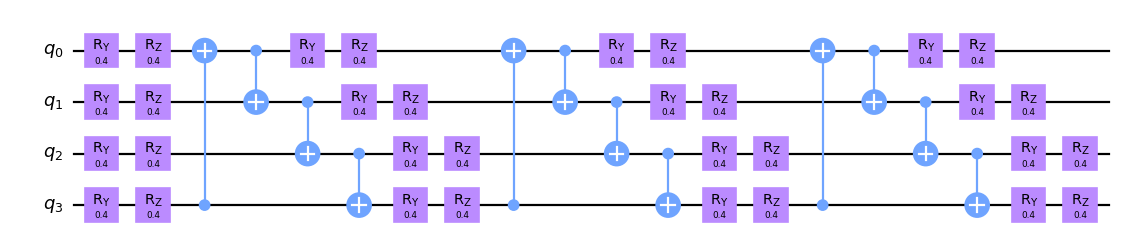

In [2]:
circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

### Specify some observables

Currently, only `Pauli` observables with phase equal to 1 are supported. Full support for `SparsePauliOp` is expected in CKT v0.3.0.

In [3]:
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Transpile the circuit, visualize the swaps, and note the depth

We choose a layout that requires two swaps to execute the gates between qubits 3 and 0 and another two swaps to return the qubits to their initial positions.

In [4]:
backend = FakeHanoi()

transpiled_qc = transpile(circuit, backend=backend, initial_layout=[0, 1, 2, 3])
print(f"Transpiled circuit depth: {transpiled_qc.depth()}")

Transpiled circuit depth: 58


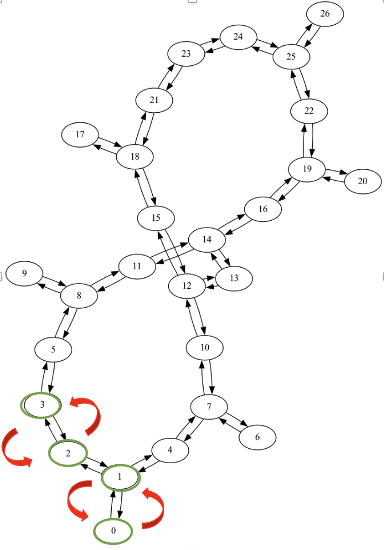

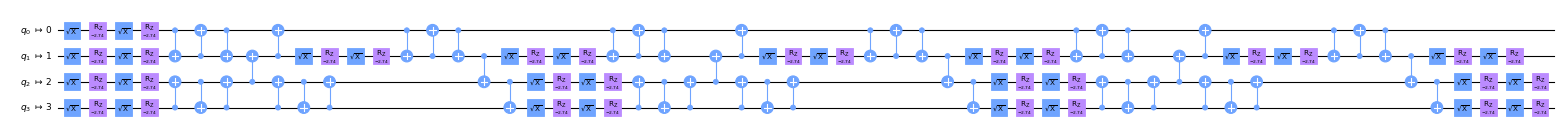

In [5]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False, fold=-1)

### Replace distant gates with `TwoQubitQPDGate`s by specifying their indices

`cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition.

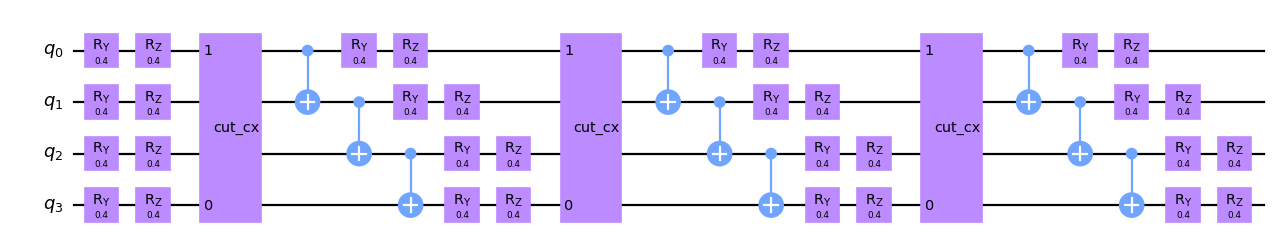

In [6]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)
qpd_circuit.draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

The sampling overhead is the factor by which the number of samples must increase for the quasiprobability decomposition to result in the same amount of error, $\epsilon$, as one would get by sampling the original circuit. Cutting CNOT and CZ gates incurs a sampling overhead of $O(9^k/\epsilon^2)$, where $k$ is the number of cuts [[Mitarai, Fujii]](https://arxiv.org/abs/1909.07534); however, other gates may have higher or lower exponential bases. For example, the sampling overhead resulting from cutting SWAP gates scales with complexity $O(49^k/\epsilon^2)$ [[Mitarai, Fujii]](https://arxiv.org/abs/2006.11174).

Here we cut three CNOT gates, resulting in a sampling overhead of $9^3$.

In [7]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


### Demonstrate that the QPD subexperiments will be shallower after cutting distant gates

Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced by more than half. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit.

Original circuit depth after transpile: 58
QPD subexperiment depth after transpile: 28


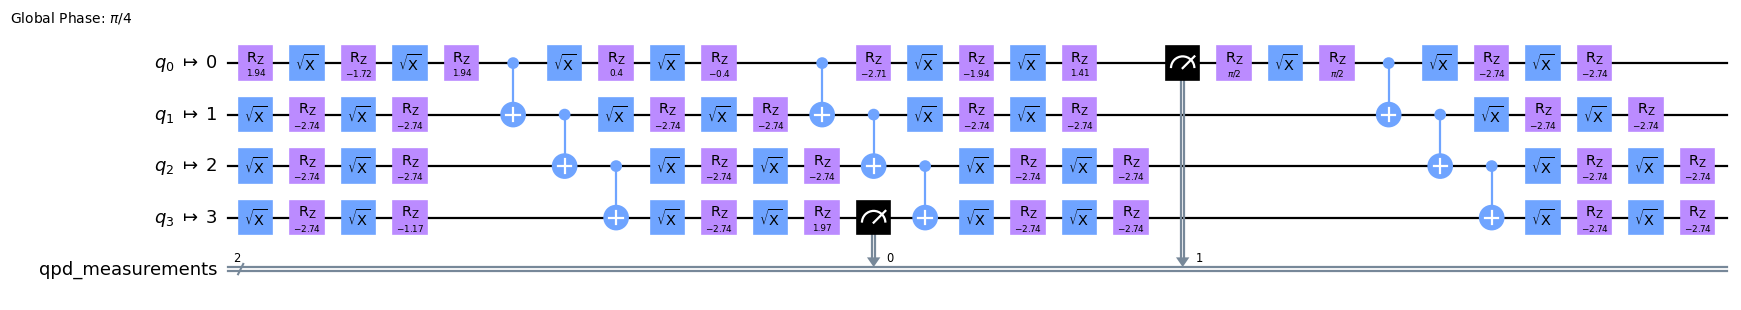

In [8]:
from circuit_knitting.cutting.qpd import decompose_qpd_instructions

# Set some arbitrary bases to which each of the 3 QPD gates should decompose
arbitrary_bases = [1, 3, 4]
for idx, basis in zip(cut_indices, arbitrary_bases):
    qpd_circuit[idx].operation.basis_id = basis

# Decompose QPDGates in a circuit into Qiskit operations and measurements
qpd_circuit_dx = decompose_qpd_instructions(qpd_circuit, [[idx] for idx in cut_indices])

# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = transpile(
    qpd_circuit_dx, backend=backend, initial_layout=[0, 1, 2, 3]
)

print(f"Original circuit depth after transpile: {transpiled_qc.depth()}")
print(f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth()}")
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

### Generate and run the subexperiments

`execute_experiments` accepts a circuit containing `TwoQubitQPDGate`s as its `circuits` argument. If a single circuit is passed in this way, a `PauliList` is the expected type of the `subobservables` argument. 

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends.

The number of weights taken from the distribution is controlled by `num_samples`. Each weight whose absolute value is above a threshold of 1 / `num_samples` will be evaluated exactly.  The remaining low-probability elements -- those in the tail of the distribution -- will then be sampled from, resulting in at most `num_samples` unique weights. Setting `num_samples` to infinity indicates that all weights should be generated rigorously, rather than by sampling from the distribution.

Much of the circuit cutting literature describes a process where we sample from the distribution, take a single shot, then sample from the distribution again and repeat; however, this is not feasible in practice. The total number of shots needed grows exponentially with the number of cuts, and taking single shot experiments via Qiskit Runtime quickly becomes untenable. Instead, we take an equivalent number of shots for each considered subexperiment and send them to the backend(s) in batches. During reconstruction, each subexperiment contributes to the final result with proportion equal to its weight.  We just need to ensure the number of shots we take is appropriate for the heaviest weights, and thus, appropriate for all weights.

In [9]:
# Keep in mind, Terra Sampler does not support mid-circuit measurements at all,
# and Aer Sampler does not support mid-circuit measurements when shots==None.
sampler = Sampler(run_options={"shots": 2**12})

quasi_dists, coefficients = execute_experiments(
    circuits=qpd_circuit,
    subobservables=observables,
    num_samples=np.inf,
    samplers=sampler,
)

`execute_experiments` returns:

- A 3D list of length-2 tuples containing a quasiprobability distribution and QPD bit information for each unique subexperiment.
- The coefficients for each subexperiment are also returned. If a sufficient number of samples is taken, the returned coefficients will be calculated exactly; otherwise, the sampled weight will be used.

### Reconstruct the expectation values

`reconstruct_expectation_values` expects `quasi_dists` and `coefficients` in the same format as returned from `execute_experiments`. `quasi_dists` is a 3D list of shape (`num_unique_samples`, `num_partitions`, `num_commuting_observ_groups`), and `coefficients` is a list with length equal to the number of unique samples. `subobservables` is the dictionary mapping qubit partition label to the associated subobservable(s). The decomposition of this circuit did not result in separation into subcircuits, so there will be only one partition represented in these outputs.

In [10]:
reconstructed_expvals = reconstruct_expectation_values(
    quasi_dists,
    coefficients,
    observables,
)

The output of `reconstruct_expectation_values` is a list of expectation values reconstructed from the smaller subexperiments -- one for each observable.

### Compare reconstructed expectation values to exact expectation values from the original circuit

In [11]:
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Simulated expectation values: [0.54180908, 0.55859375, 0.39801025, -0.27911377, 0.23406982, -0.22296143]
Exact expectation values: [0.50983039, 0.56127511, 0.36167086, -0.23006544, 0.23416169, -0.20855487]
Errors in estimation: [0.03197869, -0.00268136, 0.03633939, -0.04904833, -9.187e-05, -0.01440655]
Relative errors in estimation: [0.06272417, -0.00477727, 0.10047642, 0.21319297, -0.00039233, 0.069078]


In [12]:
import qiskit.tools.jupyter  # noqa: F401

%qiskit_version_table